This project is carried out for the following paper. 

Hengchao Chen. Quotient geometry of bounded or fixed rank correlation matrices. Under review at SIAM Journal on Matrix Analysis and Applications. 

Unique performance: QG is the only one that can interpolate correlation matrices.

In [1]:
import os
import numpy as np
import pandas as pd
import geomcorr as gc
import seaborn as sns
import matplotlib.pyplot as plt
import download_abide_preproc as dp
from scipy.linalg import sqrtm


from scipy.cluster.hierarchy import linkage, fcluster

### Real data analysis

Collect and download datasets

In [2]:
# collect and download datasets

info = pd.read_csv('Phenotypic_V1_0b_preprocessed1.csv')

base = 'C:/Users/asus-pc/Desktop/correlation/'
base_dir = 'C:/Users/asus-pc/Desktop/correlation/data/'

# collect and download datasets from AWS

#for sex in ["M", "F"]:
#    for diagnosis in ["asd", "tdc"]:
#        for site_id in info['SITE_ID'].unique():
#            dp.collect_and_download(derivative = "rois_ho", pipeline = "cpac", strategy = "filt_global", out_dir = base_dir + "Sites", less_than = 100, greater_than = 0, site = site_id, sex = sex, diagnosis = diagnosis)

# file_list
filenames = [entry.name.replace('_rois_ho.1D', '') for entry in os.scandir(base_dir + "Sites") if entry.is_file()]

filenames_selected = np.copy(filenames)


#### Frechet mean

##### Caltech

In [3]:
# selected dataset

info = pd.read_csv('Phenotypic_V1_0b_preprocessed1.csv')

info_selected = info[info["FILE_ID"].isin(filenames)].reset_index(drop = True)

# to reduct computational time, we only select one site: USM

selected_site = ["CALTECH"]

info_selected = info_selected[info_selected["SITE_ID"].isin(selected_site)].reset_index(drop = True)

# quality control and dataset selection

# determine roi label and filenames_selected

roi_label = pd.read_csv(base + 'ho_labels.csv', header = 0).iloc[1:, 0]
roi_label = ["#" + str(label) for label in roi_label]
roi_selected = np.ones(110, dtype = bool)

for i in range(info_selected.shape[0]):

    data = pd.read_csv(base_dir + "Sites/" + info_selected["FILE_ID"][i] + "_rois_ho.1D", sep = "\s+", header = 0)

    data = data[roi_label]

    if sum(np.std(data) == 0) > 8:

        filenames_selected = np.delete(filenames_selected, np.where(filenames_selected == info_selected["FILE_ID"][i]))
    
    else:

        roi_selected = np.logical_and(roi_selected, np.std(data) > 0)

roi_selected = [label for label, selected in zip(roi_label, roi_selected) if selected]

info_selected = info_selected[info_selected["FILE_ID"].isin(filenames_selected)].reset_index(drop = True)

# summary statistics
print(info_selected['AGE_AT_SCAN'].mean(), info_selected['AGE_AT_SCAN'].std(), sum(info_selected['SEX'] == 1), sum(info_selected['SEX'] == 2), sum(info_selected['DX_GROUP'] == 1), sum(info_selected['DX_GROUP'] == 2))

# label

label = info_selected['DX_GROUP']

27.454285714285717 10.231535531274428 27 8 18 17


In [4]:
# compute covariance matrix

covariance = np.zeros((len(info_selected), len(roi_selected), len(roi_selected)))

for i in range(len(info_selected)):
    
    data = pd.read_csv(base_dir + 'Sites/' + info_selected["FILE_ID"][i] + '_rois_ho.1D', sep = '\s+', header = 0)
    
    data = data[roi_selected]
    
    covariance[i] = np.cov(data.T)

# compute the rank of these correlation matrices

rank = np.zeros(len(info_selected))

for i in range(len(info_selected)):
    rank[i] = np.linalg.matrix_rank(covariance[i])

print(rank)

[62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62.
 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62. 62.]


In [5]:
# compute correlation matrices

correlation = np.zeros((len(info_selected), len(roi_selected), len(roi_selected)))

for i in range(len(info_selected)):

    correlation[i] = gc.covariance_to_correlation(covariance[i])

correlation_G1 = correlation[label == 1, ...]

correlation_G2 = correlation[label == 2, ...]

In [6]:
# compute the Frechet mean for each group

correlation_FM_G1 = gc.frechet_mean(correlation_G1, rank = 62)

correlation_FM_G2 = gc.frechet_mean(correlation_G2, rank = 62)

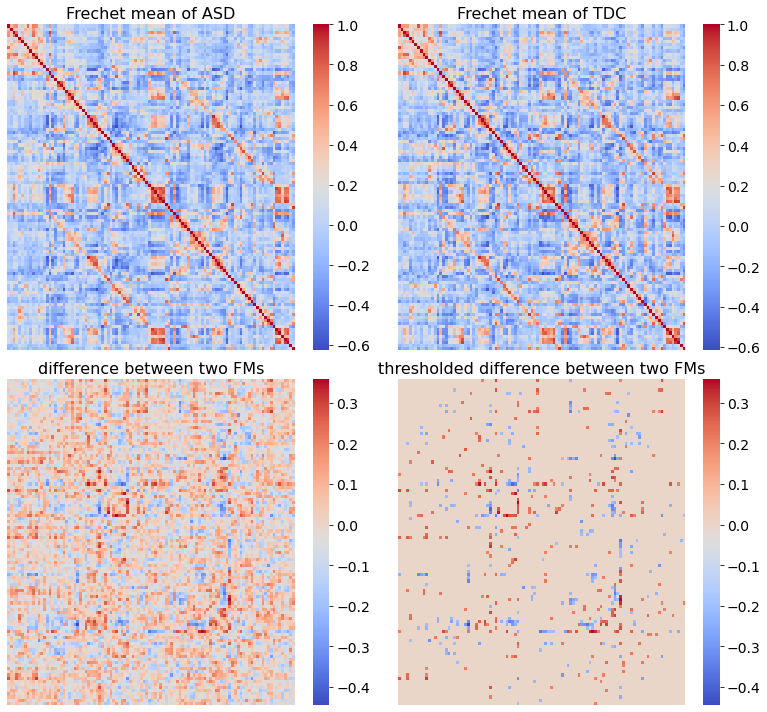

In [18]:
# visualization

plt.figure(figsize = (11, 10))

plt.subplot(2, 2, 1)

ax = sns.heatmap(correlation_FM_G1, cmap = 'coolwarm', xticklabels = False, yticklabels = False)

ax.collections[0].colorbar.ax.tick_params(labelsize=14)

plt.title('Frechet mean of ASD', fontsize = 16)

plt.subplot(2, 2, 2)

ax = sns.heatmap(correlation_FM_G2, cmap = 'coolwarm', xticklabels = False, yticklabels = False)

ax.collections[0].colorbar.ax.tick_params(labelsize=14)

plt.title('Frechet mean of TDC', fontsize = 16)

plt.subplot(2, 2, 3)

diff = correlation_FM_G1 - correlation_FM_G2

ax = sns.heatmap(diff, cmap = 'coolwarm', xticklabels = False, yticklabels = False)

ax.collections[0].colorbar.ax.tick_params(labelsize=14)

plt.title('difference between two FMs', fontsize = 16)

plt.subplot(2, 2, 4)

# thresholding

threshold = 0.2

diff[np.abs(diff) < threshold] = 0

ax = sns.heatmap(diff, cmap = 'coolwarm', xticklabels = False, yticklabels = False)

ax.collections[0].colorbar.ax.tick_params(labelsize=14)

plt.title('thresholded difference between two FMs', fontsize = 16)

plt.tight_layout()

plt.savefig('C:/Users/asus-pc/Desktop/correlation/Frechet_mean.pdf')

plt.show()

In [13]:
# compute the distance between two Frechet means

distance_FM = gc.distance(correlation_FM_G1, correlation_FM_G2, rank = 62)

print(distance_FM)

[3.69021655]
